In [1]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from lrann.datasets import DataLoader, random_train_test_split, Interactions
from lrann.estimators import ImplicitEst
from lrann.models import BilinearNet, DeepNet
from lrann.evaluations import mrr_score, precision_recall_score
from lrann.utils import is_cuda_available

In [3]:
def get_latent(n_users, n_items):
    users = np.random.uniform(-1, 1, size=n_users)
    items = np.random.uniform(-1, 1, size=n_items)
    return users, items

def get_interactions(users, items, size):
    """
    Multiply user and item latent variable and select as positive depending on the outcome
    """
    runs = 0
    while size > 0:
        user_idx = np.random.randint(users.shape[0])
        item_idx = np.random.randint(items.shape[0])
        user, item = users[user_idx], items[item_idx]
        p = max(0, user * item)
        r = np.random.binomial(2, p)  # flip coin two times and only accept if two times head
        if r == 2:
            size -= 1
            yield (user_idx, item_idx, r)
        runs += 1
    print(f"Number of runs {runs}")

In [4]:
# generate random latent features for users and items
users, items = get_latent(100, 2000)

In [5]:
# get the interactions using the latent features of users and items
interactions = np.array(list(get_interactions(users, items, 20000)))

Number of runs 346327


In [6]:
users[interactions[:,0]], items[interactions[:,1]]

(array([-0.28231202,  0.63793235, -0.74723841, ...,  0.6206833 ,
        -0.87770409,  0.67375432]),
 array([-0.81233763,  0.8088958 , -0.97571212, ...,  0.32196342,
        -0.63441649,  0.81620442]))

In [7]:
user_ids = interactions[:, 0]
item_ids = interactions[:, 1]
data = Interactions(user_ids, item_ids, n_users=users.shape[0], n_items=items.shape[0])

In [8]:
train, test = random_train_test_split(data)

In [9]:
# Switch here between MF model and deep neural network
nn_model = DeepNet(data.n_users, data.n_items, embedding_dim=1, sparse=False)
lra_model = BilinearNet(data.n_users, data.n_items, embedding_dim=1, sparse=False, biases=False)

In [11]:
lra_est = ImplicitEst(model=lra_model, n_iter=30)
nn_est = ImplicitEst(model=nn_model, n_iter=30, batch_size=128, learning_rate=1e-2)

In [12]:
nn_est.fit(train, verbose=False)
lra_est.fit(train, verbose=False)

Epoch 0: loss 0.4999997346401215
Epoch 1: loss 0.4927846946716309
Epoch 2: loss 0.4864787073135376
Epoch 3: loss 0.47267976927757266
Epoch 4: loss 0.457463262796402
Epoch 5: loss 0.4402476146221161
Epoch 6: loss 0.41087272691726684
Epoch 7: loss 0.3756320908069611
Epoch 8: loss 0.33986017525196077
Epoch 9: loss 0.29480374562740325
Epoch 10: loss 0.2567894763946533
Epoch 11: loss 0.2278917510509491
Epoch 12: loss 0.20335701435804368
Epoch 13: loss 0.1836435849070549
Epoch 14: loss 0.1699574658870697
Epoch 15: loss 0.15649981623888015
Epoch 16: loss 0.15283129197359085
Epoch 17: loss 0.14377789717912673
Epoch 18: loss 0.1367225970029831
Epoch 19: loss 0.13527223199605942
Epoch 20: loss 0.13739509826898574
Epoch 21: loss 0.13298174303770066
Epoch 22: loss 0.13089139133691788
Epoch 23: loss 0.1320822993516922
Epoch 24: loss 0.1302019743323326
Epoch 25: loss 0.1295558948814869
Epoch 26: loss 0.12965044778585433
Epoch 27: loss 0.12688810729980468
Epoch 28: loss 0.12646915823221205
Epoch 29: 

In [ ]:
prec, recall = precision_recall_score(lra_est, test)
prec.mean()

In [ ]:
prec, recall = precision_recall_score(nn_est, test)
prec.mean()

In [125]:
model = lra_est._model

In [126]:
# compare user latent features with what we got. ATTENTION, might need to flip sign of users depending on run since it's symmetric 
#users = -users  # flip depending on what you see in the next cell
res = np.vstack([model.user_embeddings.weight.data.squeeze().numpy(), users]).T
sp.stats.describe(model.user_embeddings.weight.data.squeeze().numpy())

DescribeResult(nobs=100, minmax=(-10.694535, 10.538368), mean=0.072765596, variance=33.64367, skewness=0.023720448836684227, kurtosis=-1.3475423952601735)

In [127]:
sp.stats.describe(model.item_embeddings.weight.data.squeeze().numpy())

DescribeResult(nobs=2000, minmax=(-4.824924, 4.8813105), mean=-0.02650027, variance=2.9481378, skewness=0.02396433986723423, kurtosis=-0.07017289380056324)

In [128]:
# for MF the signum should match almost always (or is completely flipped), also the magnitude matches quite often
res / np.abs(res).max(axis=0)

array([[-0.47944789, -0.36522066],
       [ 0.17438164,  0.15241724],
       [ 0.36833916,  0.08013612],
       [ 0.66410546,  0.87559182],
       [-0.45819546, -0.27736601],
       [ 0.68293535,  0.13868598],
       [-0.40249387, -0.11304998],
       [-0.69691399, -0.82572997],
       [-0.70285311, -0.46414686],
       [-0.49772357, -0.4030579 ],
       [ 0.39258325,  0.40160132],
       [-0.51338858, -0.92103392],
       [ 0.83790881,  0.75373981],
       [ 0.67183483,  0.58191324],
       [-0.7558032 , -0.73085059],
       [ 0.78412717,  0.83512732],
       [-0.09498909, -0.12576296],
       [-0.29899201, -0.1074168 ],
       [-0.6913255 , -0.56048168],
       [ 0.21878561,  0.2358601 ],
       [-0.46901182, -0.83775861],
       [-0.31449312, -0.48363643],
       [-0.3394858 , -0.5072404 ],
       [-0.44979915, -0.61004087],
       [-0.7793165 , -0.9099143 ],
       [ 0.40904472,  0.35323692],
       [-0.60261442, -0.81164743],
       [-0.18275471, -0.23996492],
       [-1.        ,

In [494]:
prec, recall = precision_recall_score(model, test)
prec.mean()

0.11538461538461536

In [47]:
def visualize(est, min_=-5, max_=5):
    X = np.linspace(-5, 5, 100)
    XX, YY = np.meshgrid(X, X)
    XX = XX.ravel()
    YY = YY.ravel()
    p = np.vstack([XX, YY]).T
    p = torch.from_numpy(p).float()
    z = est.model._forward(p)
    sns.heatmap(z)

In [504]:
# execute if model is DeepNet to plot the surface of the neural network

XX, YY = np.meshgrid(X, X)



Z = torch.sigmoid(net._h1(Z))
Z = torch.sigmoid(net._h2(Z))
Z = net._h3(Z)
Z = Z.detach().numpy().reshape(X.shape[0], -1)

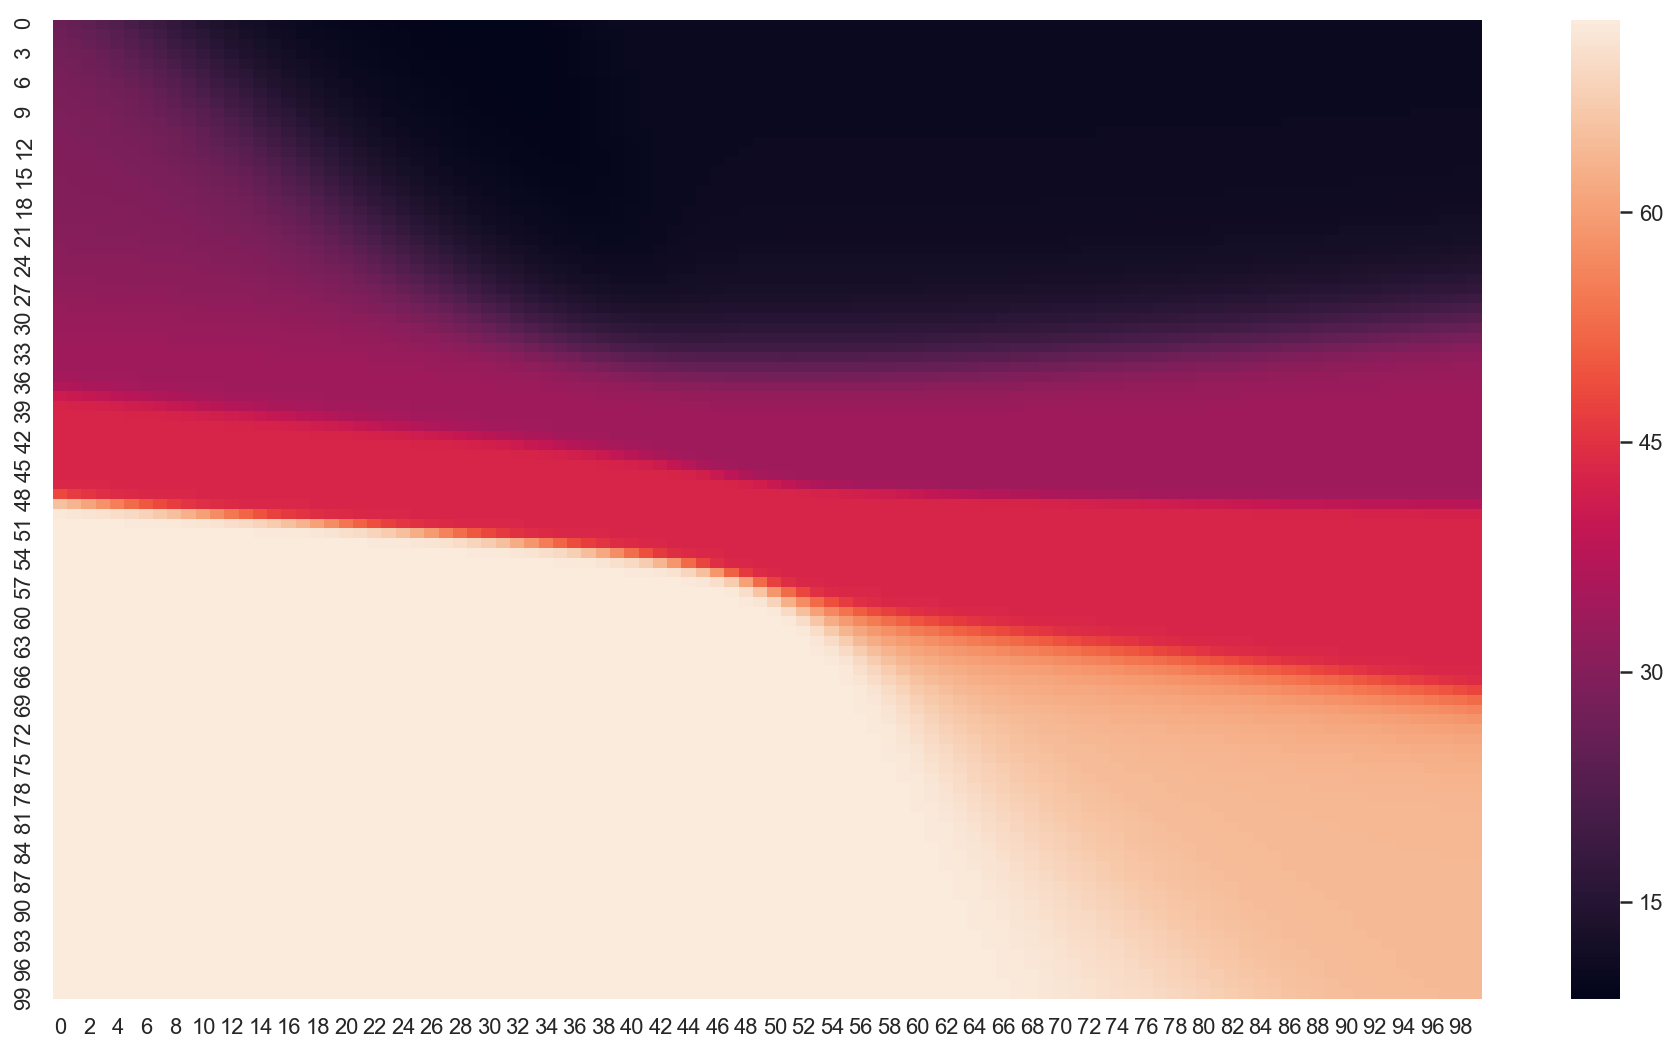

In [505]:
# surface of neural network looks quite strange!
sns.heatmap(Z)

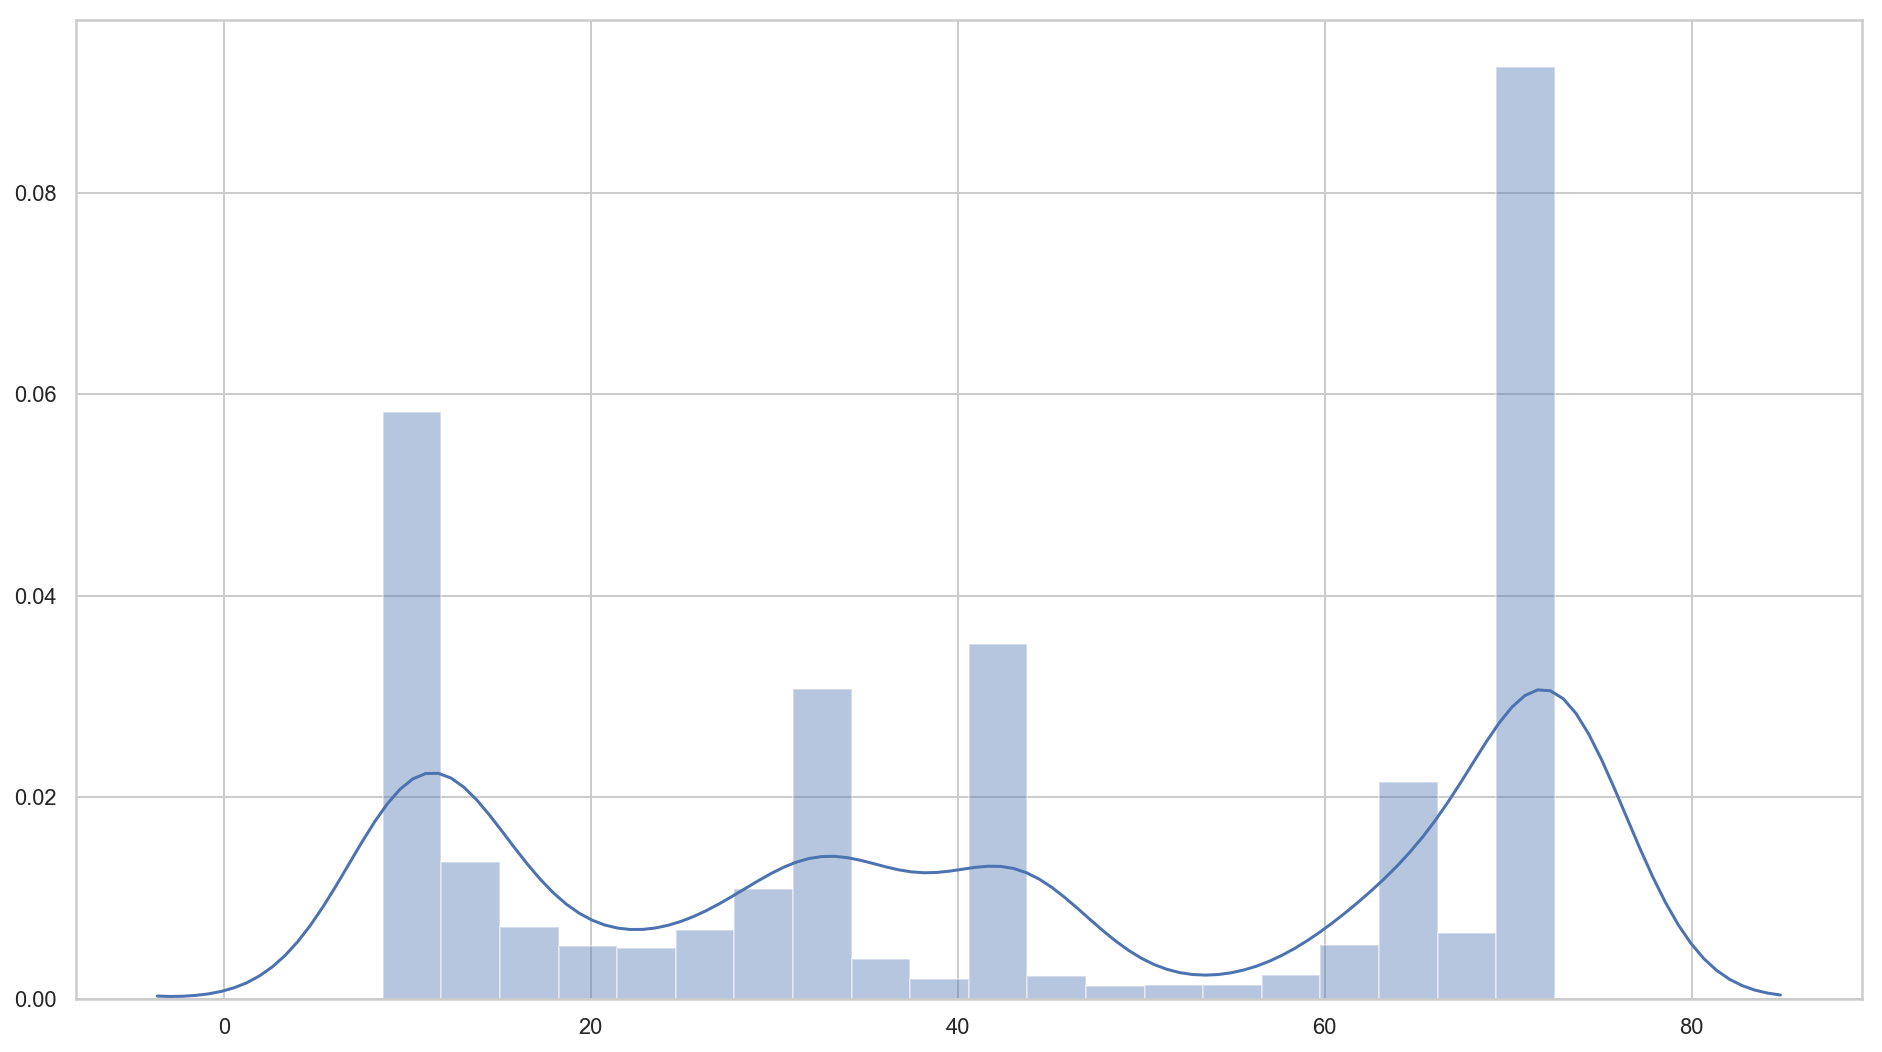

In [513]:
sns.distplot(Z.ravel(), bins=20)

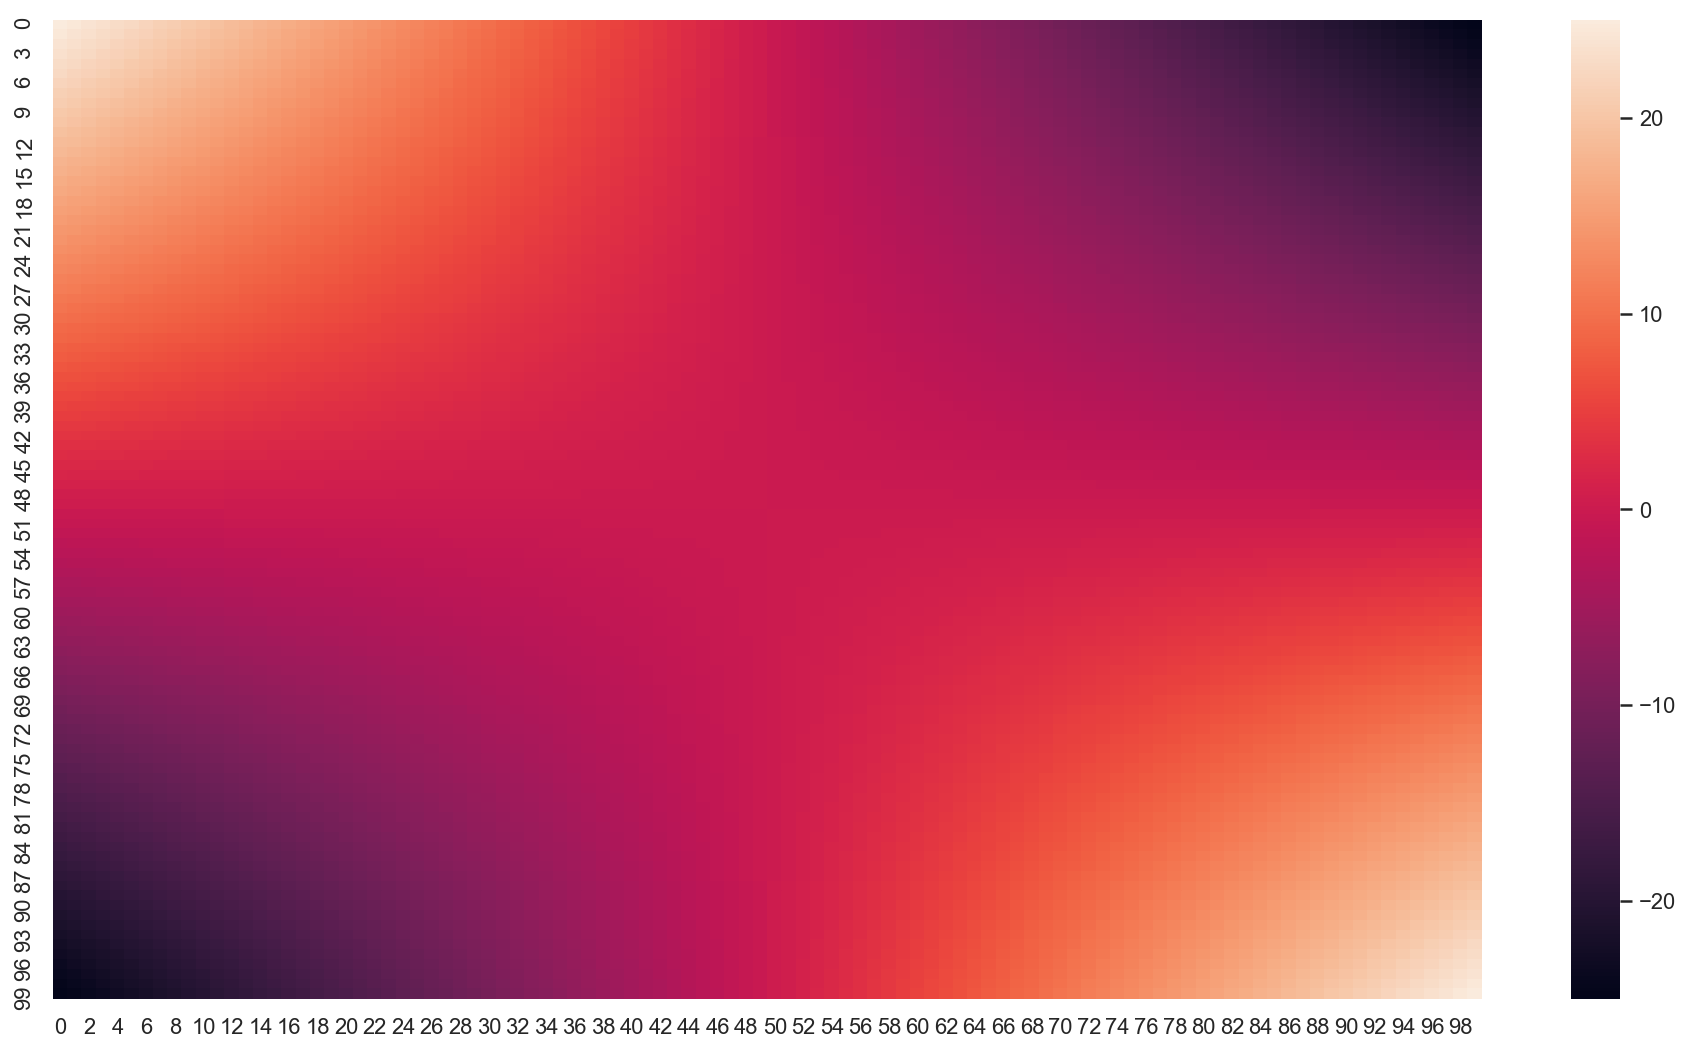

In [496]:
# execute if net is MF
X = np.linspace(-5, 5, 100)
XX, YY = np.meshgrid(X, X)
Z = (XX*YY)
sns.heatmap(Z)